# Baseline Rhythmic Assessment System

### This notebook aims at the creation of a simple baseline rhythmic assessment system which exemplifies the usage of the MAST Rhythmic subset

### Starting by creating some auxiliar functions to handle the stored data and functions that prepare the raw dataset to feed Machine Learning classifiers. The model features are the edit distance (aka Levenshtein distance) and the beat difference whereas the targets are the annotated grades (1-4) and binary assessments (fail or pass)

In [99]:
import os
import sklearn.datasets
import numpy as np

from scipy.spatial.distance import *

DATA_FOLDER = "../data/"

### storage handlers ###
def get_audio_index(file, performance_type):
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), 'list%ss' % performance_type)
    with open(file_path, 'r') as list_files:
        files = [x.strip() for x in list_files.readlines()]
        return files.index(file)
    
def get_info(index, performance_type, info_file_format):   
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), info_file_format.format(performance_type.capitalize()))
    
    with open(file_path, 'r') as infos:
        info = infos.readlines()[index]
        return [int(x) for x in info.split()]
  

### distance measures for binary vectors ###
def levenshtein(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def beat_difference(s1, s2):
    return abs(s1.count(1) - s2.count(1))
    
def get_class_for_performance(audio_name, multiclass=True):
    annotations = []
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(DATA_FOLDER, "Performances Annotations")):
        for file_name in filenames:
            if file_name == 'listfiles.txt':
                pass
            else:
                with open(os.path.join(dirpath, file_name), 'r') as annotator_file:
                    for annotation in annotator_file.readlines():
                        annotation = annotation.strip()
                        if audio_name in annotation:
                            grade = int(annotation.split()[1].split('Grade:')[1])
                            annotations.append(grade)
                            
    # the class of a performance is the mode of its annotations
    if multiclass:
        return max(set(annotations), key=annotations.count) 
    # the binary class of a performance is whether it was accepted or not
    return 1 if 'pass' in audio_name else 0
  
def load_rhythmic_performances():
    features = []
    target_multiclass = []
    target_binary = []
    
# vector distances in the euclidean spaces doesn't say much
#     DISTANCE_FUNCTIONS = [levenshtein, euclidean, cosine, braycurtis, canberra, chebyshev, cityblock, correlation, dice, hamming, jaccard, kulsinski, matching, rogerstanimoto, russellrao, sokalmichener, sokalsneath, sqeuclidean, yule]
    DISTANCE_FUNCTIONS = [levenshtein, beat_difference]
    
    with open('../data/Performances Annotations/listfiles.txt', 'r') as list_of_files,\
         open('../data/Only Performances/listperformances', 'r') as performances_file,\
         open('../data/Only Performances/MAST Onsets [Performances] [BINS]', 'r') as performances_onsets,\
         open('../data/Only References/listreferences', 'r') as references_file,\
         open('../data/Only References/MAST Onsets [References] [BINS]', 'r') as references_onsets:        
        
        for performance in list_of_files.readlines():
            performance = performance.strip()
            index = get_audio_index(performance,'performance')
            
            performance_bins = get_info(index, 'performance', 'MAST Onsets [{}s] [BINS]')
            reference_bins = get_info(index, 'reference', 'MAST Onsets [{}s] [BINS]')              
            
            # model features
            features.append([distance_function(performance_bins, reference_bins) for distance_function in DISTANCE_FUNCTIONS])         
            
            # model targets
            target_multiclass.append(get_class_for_performance(performance))
            target_binary.append(get_class_for_performance(performance, multiclass=False))
            
    return sklearn.datasets.base.Bunch(data=np.asarray(features), target_multiclass=np.asarray(target_multiclass), target_binary=np.asarray(target_binary))   

### Next, we use the prepared data to train/test a Logistic Regression model. We are using a 10-fold cross validation (test size: 30%). The learning curves are plotted below.

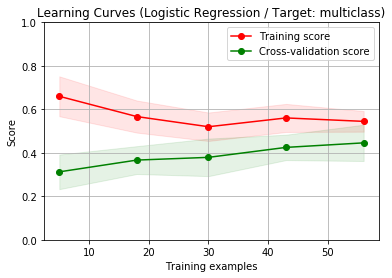

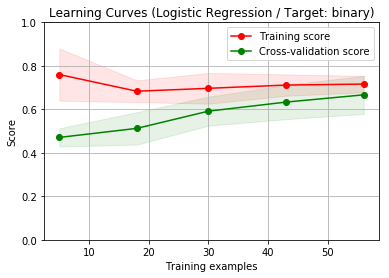

In [101]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# loading rhythmic dataset
mast = load_rhythmic_performances()

X, y_b = mast.data, mast.target_binary

title = r"Learning Curves (Logistic Regression / Target: multiclass)"
# plotting learning curve for a multiclass logistic regression classifier (1-4)
# using 10-fold cross validation (minimum testing set: 30%)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y_m, (0, 1), cv=cv)

title = r"Learning Curves (Logistic Regression / Target: binary)"
# plotting learning curve for a binary logistic regression classifier (pass/fail)
# using 10-fold cross validation (minimum testing set: 30%)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y_b, (0, 1), cv=cv)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$/ Target: multiclass)"

plt.show()